# **MS1 calibration for shear fatigue behavior - not included at Euro-C**

Study not included at Euro-C. The notebook can be reused for calibration

In [1]:
%matplotlib widget
import numpy as np
np.seterr(divide='ignore', invalid='ignore') 
import matplotlib.pylab as plt
from ibvpy.bcond import BCSlice, BCDof
from ibvpy.fets import FETS3D8H
from ibvpy.fets import FETS2D4Q
from ibvpy.tmodel.mats3D import MATS3DElastic
import bmcs_matmod.ms1.concrete_material_db as mp_db
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from ibvpy.sim.tstep_bc import TStepBC
from ibvpy.xmodel.xdomain_fe_grid import XDomainFEGrid
from ibvpy.xmodel.xdomain_fe_grid_axisym import XDomainFEGridAxiSym
from ibvpy.api import TStepBC, TFCyclicNonsymmetricConstant, TFBilinear
from mayavi import mlab
from bmcs_matmod.ms1 import MS13D
from bmcs_matmod.ms1 import MS13D_damage_jir
from ibvpy.tmodel.mats3D.mats3D_microplane.vmats3D_mpl_d_eeq import \
    MATS3DMplDamageEEQ
from ibvpy.bcond import BCSliceI, BCDof
from ibvpy.tfunction import TimeFunction, TFSelector, TFCyclicSin, TFCyclicNonsymmetricConstant
import copy

In [2]:
def get_damage(m):   
    radial_damage = []
    hoop_damage = []
    shear_damage = []

    for i in range(len(m.hist.state_vars)):
        omega_T_Emn = np.average(m.hist.state_vars[i][0]['omega_T_Emn'],axis=1)
        omega_N_Emn = np.average(m.hist.state_vars[i][0]['omega_N_Emn'],axis=1)
        beta_N = 1. - omega_N_Emn
        beta_T = 1. - omega_T_Emn
        # beta_T = 0.75*copy.deepcopy(beta_T) +0.25*copy.deepcopy(beta_T)*copy.deepcopy(beta_N)
        delta = m_inelastic.DELTA

        beta_ijkl = np.einsum('n, ...n,ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_N, m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN,
                              m_inelastic._MPN) + \
                    0.25 * (np.einsum('n, ...n,ni, nk, jl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,ni, nl, jk -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nk, il -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nl, ik -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) -
                            4.0 * np.einsum('n, ...n, ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN,
                                            m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN))

        radial_damage.append(1-(beta_ijkl**2)[0,1,1,1,1])
        hoop_damage.append(1-(beta_ijkl**2)[0,2,2,2,2])
        shear_damage.append(1-((beta_ijkl)[0,1,0,1,0]*2)**2)
    return radial_damage, hoop_damage, shear_damage


In [3]:
def get_omega_N(m):
    omega_N_11 = np.zeros((len(m.hist.state_vars),8))
    for i in range(len(m.hist.state_vars)):
        omega_N_11[i] = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        
    omega_N_01 = np.zeros((len(m.hist.state_vars),20))
    for i in range(len(m.hist.state_vars)):
        omega_N_01[i] = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
    return omega_N_01, omega_N_11 

In [4]:
def get_omega_T(m):
    omega_T_11 = np.zeros((len(m.hist.state_vars),8))
    for i in range(len(m.hist.state_vars)):
        omega_T_11[i] = np.array([ m.hist.state_vars[i][0]['omega_T_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        
    omega_T_01 = np.zeros((len(m.hist.state_vars),20))
    for i in range(len(m.hist.state_vars)):
        omega_T_01[i] = np.array([ m.hist.state_vars[i][0]['omega_T_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        
    return omega_T_01, omega_T_11   

In [5]:
def get_sigma_N(m):
    
    sigma_N_11 = np.zeros((len(m.hist.state_vars),8))
    for i in range(len(m.hist.state_vars)):
        eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
        eps_N_Emn = m_inelastic._get_e_N_Emn_2(eps_Emab)
        eps_N_Emn = np.array([ eps_N_Emn[0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        E_N = m_inelastic.E / (1.0 - 2.0 * m_inelastic.nu)
        omega_N_Emn = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        eps_N_p_Emn = np.array([ m.hist.state_vars[i][0]['eps_N_p_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        sigma_N_11[i] = (1.0 - omega_N_Emn ) * E_N * (eps_N_Emn - eps_N_p_Emn)
        
    sigma_N_01 = np.zeros((len(m.hist.state_vars),20))
    for i in range(len(m.hist.state_vars)):
        eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
        eps_N_Emn = m_inelastic._get_e_N_Emn_2(eps_Emab)
        eps_N_Emn = np.array([ eps_N_Emn[0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        E_N = m_inelastic.E / (1.0 - 2.0 * m_inelastic.nu)
        omega_N_Emn = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        eps_N_p_Emn = np.array([ m.hist.state_vars[i][0]['eps_N_p_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        sigma_N_01[i] = (1.0 - omega_N_Emn ) * E_N * (eps_N_Emn - eps_N_p_Emn)
    
    sigma_radial = np.zeros(len(m.hist.state_vars))
    for i in range(len(m.hist.state_vars)):
        eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
        omega_T_Emn = np.average(m.hist.state_vars[i][0]['omega_T_Emn'],axis=1)
        omega_N_Emn = np.average(m.hist.state_vars[i][0]['omega_N_Emn'],axis=1)
        eps_T_pi_Emna = np.average(m.hist.state_vars[i][0]['eps_T_pi_Emna'],axis=1)
        eps_N_p_Emn = np.average(m.hist.state_vars[i][0]['eps_N_p_Emn'],axis=1)
        
        beta_N = 1. - omega_N_Emn
        beta_T = 1. - omega_T_Emn
        # beta_T = 0.75*copy.deepcopy(beta_T) +0.25*copy.deepcopy(beta_T)*copy.deepcopy(beta_N)
        delta = m_inelastic.DELTA

        beta_Emabcd = np.einsum('n, ...n,ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_N, m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN,
                              m_inelastic._MPN) + \
                    0.25 * (np.einsum('n, ...n,ni, nk, jl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,ni, nl, jk -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nk, il -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nl, ik -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) -
                            4.0 * np.einsum('n, ...n, ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN,
                                            m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN))

        D_Emabcd = np.einsum(
                     '...ijab, abef, ...cdef->...ijcd',
                     beta_Emabcd, m_inelastic.D_abef, beta_Emabcd
                )

        eps_p_Emab = (
        np.einsum('n,...n,na,nb->...ab',
                  m_inelastic._MPW, eps_N_p_Emn, m_inelastic._MPN, m_inelastic._MPN) +
        0.5 * (
                np.einsum('n,...nf,na,fb->...ab',
                          m_inelastic._MPW, eps_T_pi_Emna, m_inelastic._MPN, m_inelastic.DELTA) +
                np.einsum('n,...nf,nb,fa->...ab',
                          m_inelastic._MPW, eps_T_pi_Emna, m_inelastic._MPN, m_inelastic.DELTA)
        )
        )
        eps_e_Emab = eps_Emab - eps_p_Emab

        sig_Emab = np.einsum(
            '...abcd,...cd,...ab->...ab',
            D_Emabcd, eps_e_Emab, m_inelastic.DELTA
                ) 
        sigma_11 = sig_Emab[0,:,1,1]
        sigma_radial[i] = max(sigma_11)
        
    return sigma_N_01, sigma_N_11, sigma_radial

In [6]:
def get_sigma(m,idx):
    
    
    sigma_radial = np.zeros(len(m.hist.state_vars))
    sigma_hoop = np.zeros(len(m.hist.state_vars))
    sigma_shear = np.zeros(len(m.hist.state_vars))
    
    for i in range(len(m.hist.state_vars)):
        eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
        omega_T_Emn = np.average(m.hist.state_vars[i][0]['omega_T_Emn'],axis=1)
        omega_N_Emn = np.average(m.hist.state_vars[i][0]['omega_N_Emn'],axis=1)
        eps_T_pi_Emna = np.average(m.hist.state_vars[i][0]['eps_T_pi_Emna'],axis=1)
        eps_N_p_Emn = np.average(m.hist.state_vars[i][0]['eps_N_p_Emn'],axis=1)
        
        beta_N = 1. - omega_N_Emn
        beta_T = 1. - omega_T_Emn
        # beta_T = 0.75*copy.deepcopy(beta_T) + 0.25**copy.deepcopy(beta_T)**copy.deepcopy(beta_N)
        delta = m_inelastic.DELTA
        beta_Emabcd = np.einsum('n, ...n,ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_N, m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN,
                              m_inelastic._MPN) + \
                    0.25 * (np.einsum('n, ...n,ni, nk, jl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,ni, nl, jk -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nk, il -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nl, ik -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) -
                            4.0 * np.einsum('n, ...n, ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN,
                                            m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN))

        D_Emabcd = np.einsum(
                     '...ijab, abef, ...cdef->...ijcd',
                     beta_Emabcd, m_inelastic.D_abef, beta_Emabcd
                )

        eps_p_Emab = (
        np.einsum('n,...n,na,nb->...ab',
                  m_inelastic._MPW, eps_N_p_Emn, m_inelastic._MPN, m_inelastic._MPN) +
        0.5 * (
                np.einsum('n,...nf,na,fb->...ab',
                          m_inelastic._MPW, eps_T_pi_Emna, m_inelastic._MPN, m_inelastic.DELTA) +
                np.einsum('n,...nf,nb,fa->...ab',
                          m_inelastic._MPW, eps_T_pi_Emna, m_inelastic._MPN, m_inelastic.DELTA)
        )
        )
        eps_e_Emab = eps_Emab - eps_p_Emab

        sig_Emab = np.einsum(
            '...abcd,...cd,...ab->...ab',
            D_Emabcd, eps_e_Emab, m_inelastic.DELTA
                ) 
        sigma_11 = sig_Emab[0,:,1,1]
        sigma_22 = sig_Emab[0,:,2,2]
        sigma_01 = sig_Emab[0,:,0,1]
        
        sigma_radial[i] = sigma_11[idx]
        sigma_hoop[i] = sigma_22[idx]
        sigma_shear[i] = sigma_01[idx]

    return sigma_radial, sigma_hoop, sigma_shear

In [7]:
# omega_T_Emn = np.average(m.hist.state_vars[-1][0]['omega_T_Emn'],axis=1)
# omega_N_Emn = np.average(m.hist.state_vars[-1][0]['omega_N_Emn'],axis=1)
# beta_N = 1. - omega_N_Emn
# beta_T = 1. - omega_T_Emn
# delta = m_inelastic.DELTA

# beta_ijkl = np.einsum('n, ...n,ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_N, m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN,
#                       m_inelastic._MPN) + \
#             0.25 * (np.einsum('n, ...n,ni, nk, jl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
#                     np.einsum('n, ...n,ni, nl, jk -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
#                     np.einsum('n, ...n,nj, nk, il -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
#                     np.einsum('n, ...n,nj, nl, ik -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) -
#                     4.0 * np.einsum('n, ...n, ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN,
#                                     m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN))

In [8]:
# Reference parameters

CAxisymm = dict(
    E = 39226,
    nu = 0.18,
    Ad = 7000.0,
    eps_0 = 0.00001,
    K_N = 1000.,
    sigma_N_0 = 40.,
    gamma_N = 60000.,
    sigma_T_0 = 2.0,
    K_T = 500.0,
    gamma_T = 5000,
    S_T = 0.006,
    c_T = 10.,
    r_T = 15.,
    m_T = 0.1,
    p_T = 6.
)
# CAxisymm = dict(
#     E = 40e+3,
#     nu = 0.2,
#     Ad = 7000.0,
#     eps_0 = 0.0001,
#     K_N = 17000.,
#     sigma_N_0 = 45.,
#     gamma_N = 20000.,
#     sigma_T_0 = 2.0,
#     K_T = 20000.0,
#     gamma_T = 500000,
#     S_T = 0.01,
#     c_T = 9.,
#     r_T = 15.,
#     m_T = 0.1,
#     p_T = 10.
# )

# CAxisymm = dict(
#     E = 42e+3,
#     nu = 0.2,
#     Ad = 1800.0,
#     eps_0 = 0.0001,
#     K_N = 17000.,
#     sigma_N_0 = 45.,
#     gamma_N = 9000.,
#     sigma_T_0 = 2.0,
#     K_T = 20000.0,
#     gamma_T = 500000,
#     S_T = 0.03,
#     c_T = 9.,
#     r_T = 15.,
#     m_T = 0.1,
#     p_T = 10.
# )




## Unit element Axisymm 

In [9]:
n_x_e = 3
n_inner_y_e = 1
n_outer_y_e = 1
L_x = 90.0 # [mm]
d_x = L_x / n_x_e
R_in = 25 # [mm]
dR = 4 # [mm]
R_out = 50 # [mm]
len_notch = 30
n_notch = 1

xmodel = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0+n_notch*d_x, R_in),
                               coord_max=(L_x-n_notch*d_x, R_in+dR),
                               shape=(n_x_e-2*n_notch, 1),
                               fets=FETS2D4Q())

m_inelastic = MS13D(**CAxisymm)
m_elastic = MATS3DElastic(E=40000, nu=0.18)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [10]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=0.1)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=0.1)

In [11]:
slide_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[0], value=0.0)
slide_upper_dofs = slide_upper_slice.dofs

slide_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[0], value=0.0)
slide_lower_dofs = slide_lower_slice.dofs

confinement_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[1], value=0.0)
confinement_upper_dofs = confinement_upper_slice.dofs

confinement_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[1], value=0.0)
confinement_lower_dofs = confinement_lower_slice.dofs


## Monotonic - dc

In [12]:
m_list_monotnonic = []
# CAxisymm['m_T'] = 0.15
# CAxisymm['p_T'] = 7
# m_inelastic = MS13D(**CAxisymm)
# compression_level = np.linspace(-20,10,3)
compression_level = np.array([0,-5,-15,-30])

w_max = 0.1

for compression in compression_level:
    m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
    )
    # Shear bc
    slide = 0.1
    compression_stress = compression

    inner_fixed_0 = slide_lower_slice
    inner_fixed_1 = confinement_lower_slice

    compression_force = compression_stress * 2 * np.pi * (R_in + dR) * len_notch  / (len(confinement_upper_dofs))
    upper_compression_force = [BCDof(var='f', dof=dof, value=compression_force, 
                                     time_function=tf_precrompression)
                               for dof in confinement_upper_dofs]
    

    
    # upper_compression_force[0].value *= 0.5
    # upper_compression_force[-1].value *= 0.5

    slide_upper = [BCDof(var='u', dof=dof, value=slide, time_function=tf_sliding)
                         for dof in slide_upper_dofs]
    
#     slide_upper[0].value *= 1.5
#     slide_upper[-1].value *= 0.5
    
    
    bc1 = [inner_fixed_0, inner_fixed_1] + slide_upper + upper_compression_force

    m.bc=bc1
    m.hist.vis_record = {
    #    'strain': Vis3DTensorField(var='eps_ab'),
        'stress': Vis3DTensorField(var='sig_ab'),
        #        'kinematic hardening': Vis3DStateField(var='z_a')
    }

    s = m.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tline.step = 0.005
    # Accessing the following property - ensures serialization
    s.tstep.fe_domain.serialized_subdomains
    s.reset()
    # s.run()
    try:
        s.run()
    except:
        # m_list_monotnonic.append(m)
        pass
    m_list_monotnonic.append(m)

Text(0.5, 0.01, "{'E': 39226, 'nu': 0.18, 'Ad': 7000.0, 'eps_0': 1e-05, 'K_N': 1000.0, 'sigma_N_0': 40.0, 'gamma_N': 60000.0, 'sigma_T_0': 2.0, 'K_T': 500.0, 'gamma_T': 5000, 'S_T': 0.006, 'c_T': 10.0, 'r_T': 15.0, 'm_T': 0.1, 'p_T': 6.0}")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
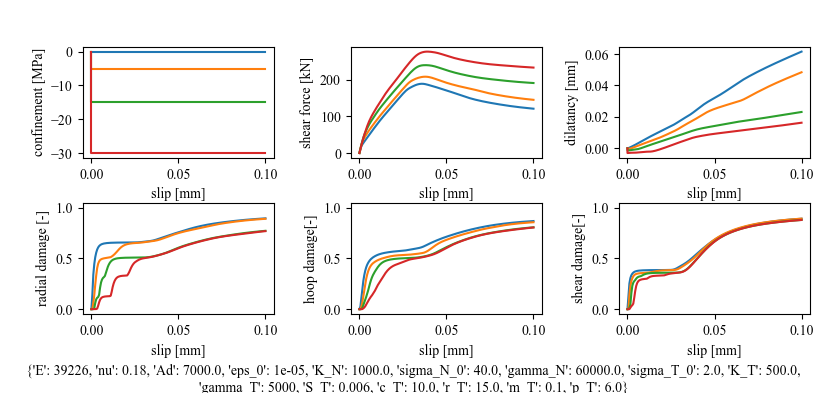

In [16]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"




fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2, 3,figsize=(21*cm, 10*cm))



for m,compression in zip(m_list_monotnonic,compression_level):
    U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
    U_dilatancy  =m.hist.U_t[:, confinement_upper_dofs[0]]
    F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
    radial_damage, hoop_damage, shear_damage = get_damage(m)

    F_confinement = np.sum(m.hist.F_t[:, confinement_upper_dofs], axis=-1)
    max_F.append(max(abs(F_slide)))
    
    ax1.plot(U_slide, F_confinement/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)), label=str(compression))
    ax1.set_ylabel('confinement [MPa]', fontsize=10)
    ax1.set_xlabel('slip [mm]', fontsize=10)
    
    ax2.plot(U_slide, F_slide/1000, label=str(compression))
    ax2.set_ylabel('shear force [kN]', fontsize=10)
    ax2.set_xlabel('slip [mm]', fontsize=10)
    
    ax3.plot(U_slide, U_dilatancy, label=str(compression))
    ax3.set_ylabel('dilatancy [mm]', fontsize=10)
    ax3.set_xlabel('slip [mm]', fontsize=10)
    
    
    # ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
    ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
    ax4.set_ylabel('radial damage [-]', fontsize=10)
    ax4.set_xlabel('slip [mm]', fontsize=10)
    ax4.set_ylim(-0.05,1.05)
    
    ax5.plot(U_slide, hoop_damage, label='hoop damage'+str(compression))
    ax5.set_ylabel('hoop damage[-]', fontsize=10)
    ax5.set_xlabel('slip [mm]', fontsize=10)
    ax5.set_ylim(-0.05,1.05)
    
    # ax6.plot(F_slide/1000, shear_damage, label='shear damage'+str(compression))
    ax6.plot(U_slide, shear_damage, label='shear damage'+str(compression))
    ax6.set_ylabel('shear damage[-]', fontsize=10)
    ax6.set_xlabel('slip [mm]', fontsize=10)
    ax6.set_ylim(-0.05,1.05)
    
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

txt=str(CAxisymm)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)

# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_monotonic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_monotonic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

In [17]:
max_F

[189585.70479604788,
 208953.07508211062,
 240573.03845406527,
 277615.42381486006]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
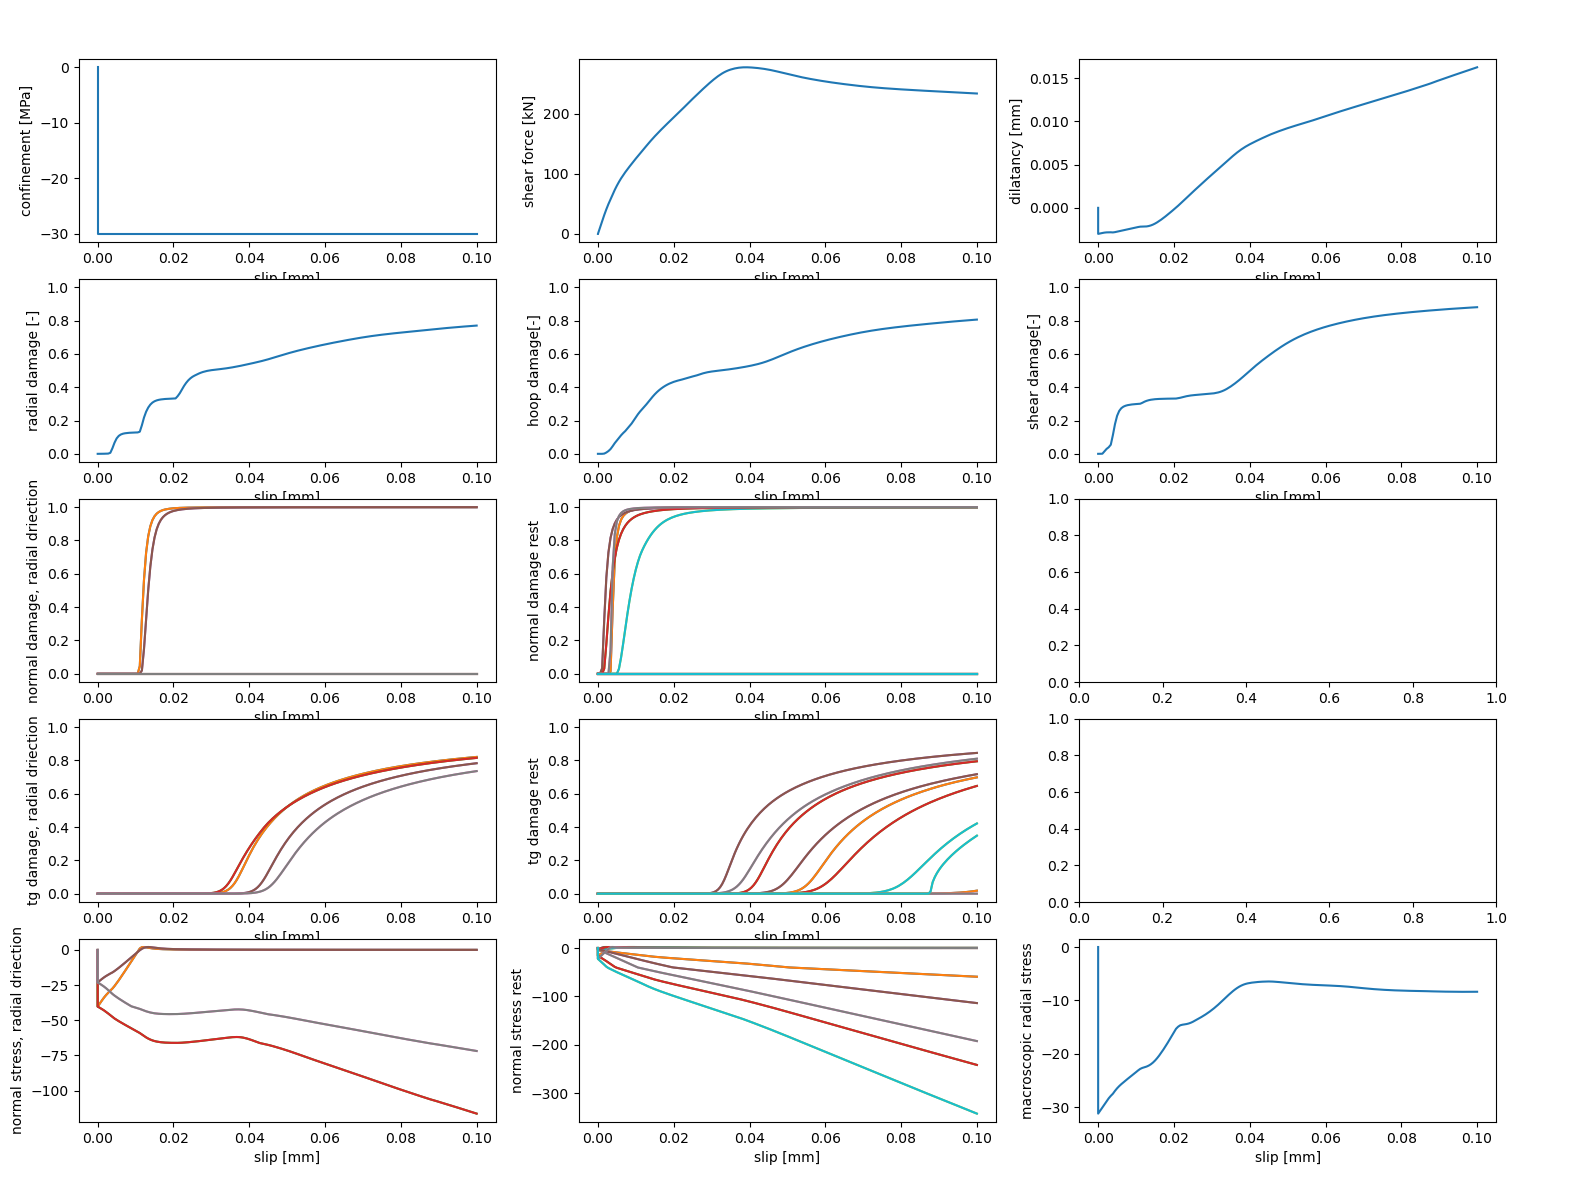

In [18]:
plt.style.use('default')

# plt.tight_layout()

cm = 1/2.54  # centimeters in inches
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6), (ax7,ax8,ax9), (ax10,ax11,ax12), (ax13,ax14,ax15)) = plt.subplots(5, 3,figsize=(40*cm, 30*cm))

# txt=str(CAxisymm)


idx = 3
m = m_list_monotnonic[idx]
compression = compression_level[idx]
# plt.rcParams["font.family"] = "Times New Roman"
 
    
U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
U_dilatancy  =m.hist.U_t[:, confinement_upper_dofs[0]]
F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
radial_damage, hoop_damage, shear_damage = get_damage(m)

F_confinement = np.sum(m.hist.F_t[:, confinement_upper_dofs], axis=-1)


ax1.plot(U_slide, F_confinement/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)), label=str(compression))
ax1.set_ylabel('confinement [MPa]', fontsize=10)
ax1.set_xlabel('slip [mm]', fontsize=10)

ax2.plot(U_slide, F_slide/1000, label=str(compression))
ax2.set_ylabel('shear force [kN]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(U_slide, U_dilatancy, label=str(compression))
ax3.set_ylabel('dilatancy [mm]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)


# ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
ax4.set_ylabel('radial damage [-]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
ax4.set_ylim(-0.05,1.05)

ax5.plot(U_slide, hoop_damage, label='hoop damage'+str(compression))
ax5.set_ylabel('hoop damage[-]', fontsize=10)
ax5.set_xlabel('slip [mm]', fontsize=10)
ax5.set_ylim(-0.05,1.05)

# ax6.plot(F_slide/1000, shear_damage, label='shear damage'+str(compression))
ax6.plot(U_slide, shear_damage, label='shear damage'+str(compression))
ax6.set_ylabel('shear damage[-]', fontsize=10)
ax6.set_xlabel('slip [mm]', fontsize=10)
ax6.set_ylim(-0.05,1.05)

omega_N_01, omega_N_11 = get_omega_N(m) 
ax7.plot(U_slide, omega_N_11)
ax7.set_ylabel('normal damage, radial driection', fontsize=10)
ax7.set_xlabel('slip [mm]', fontsize=10)
ax7.set_ylim(-0.05,1.05)


ax8.plot(U_slide, omega_N_01, label='shear damage'+str(compression))
ax8.set_ylabel('normal damage rest', fontsize=10)
ax8.set_xlabel('slip [mm]', fontsize=10)
ax8.set_ylim(-0.05,1.05)

omega_T_01, omega_T_11 = get_omega_T(m) 
ax10.plot(U_slide, omega_T_11)
ax10.set_ylabel('tg damage, radial driection', fontsize=10)
ax10.set_xlabel('slip [mm]', fontsize=10)
ax10.set_ylim(-0.05,1.05)


ax11.plot(U_slide, omega_T_01, label='shear damage'+str(compression))
ax11.set_ylabel('tg damage rest', fontsize=10)
ax11.set_xlabel('slip [mm]', fontsize=10)
ax11.set_ylim(-0.05,1.05)
    
sigma_N_01, sigma_N_11, sigma_radial = get_sigma_N(m) 
ax13.plot(U_slide, sigma_N_11)
ax13.set_ylabel('normal stress, radial driection', fontsize=10)
ax13.set_xlabel('slip [mm]', fontsize=10)
# ax13.set_ylim(-0.05,1.05)


ax14.plot(U_slide, sigma_N_01, label='shear damage'+str(compression))
ax14.set_ylabel('normal stress rest', fontsize=10)
ax14.set_xlabel('slip [mm]', fontsize=10)
# ax14.set_ylim(-0.05,1.05)

ax15.plot(U_slide, sigma_radial)
ax15.set_ylabel('macroscopic radial stress', fontsize=10)
ax15.set_xlabel('slip [mm]', fontsize=10)

left  = 0.05  # the left side of the subplots of the figure
right = 0.95  # the right side of the subplots of the figure
bottom = 0.05   # the bottom of the subplots of the figure
top = 0.95      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


### m parameter

In [16]:
CAxisymm = dict(
    E = 40e+3,
    nu = 0.2,
    Ad = 7000.0,
    eps_0 = 0.00001,
    K_N = 200.,
    sigma_N_0 = 40.,
    gamma_N = 5000.,
    sigma_T_0 = 2.0,
    K_T = 100.0,
    gamma_T = 20000,
    S_T = 0.005,
    c_T = 5.,
    r_T = 6.,
    m_T = 0.0,
    p_T = 6.
)

In [17]:
m_list_parameter_m = []
# compression_level = np.linspace(-20,10,3)
compression_level = np.array([0,-5,-15,-30])
m_parameter_list = np.array([0, 0.05, 0.1, 0.2, 0.3])

w_max = 0.03
for m_parameter in m_parameter_list:
    CAxisymm['m_T'] = m_parameter
    m_inelastic = MS13D(**CAxisymm)
    for compression in compression_level:
        
        m = TStepBC(
        domains=[(xmodel, m_inelastic),
                 ]
        )
        # Shear bc
        slide = 0.06
        compression_stress = compression

        inner_fixed_0 = slide_lower_slice
        inner_fixed_1 = confinement_lower_slice

        compression_force = compression_stress * 2 * np.pi * (R_in + dR) * len_notch  / (len(confinement_upper_dofs))
        upper_compression_force = [BCDof(var='f', dof=dof, value=compression_force, 
                                         time_function=tf_precrompression)
                                   for dof in confinement_upper_dofs]



        slide_upper = [BCDof(var='u', dof=dof, value=slide, time_function=tf_sliding)
                             for dof in slide_upper_dofs]


        bc1 = [inner_fixed_0, inner_fixed_1] + slide_upper + upper_compression_force

        m.bc=bc1
        m.hist.vis_record = {
        #    'strain': Vis3DTensorField(var='eps_ab'),
            'stress': Vis3DTensorField(var='sig_ab'),
            #        'kinematic hardening': Vis3DStateField(var='z_a')
        }

        s = m.sim
        s.tloop.verbose = False
        s.tloop.k_max = 1000
        s.tline.step = 0.01
        # Accessing the following property - ensures serialization
        s.tstep.fe_domain.serialized_subdomains
        s.reset()
        # s.run()
        try:
            s.run()
        except:
            pass
        m_list_parameter_m.append(m)

0.0
0.05
0.1


ValueError: x and y must have same first dimension, but have shapes (16,) and (15,)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
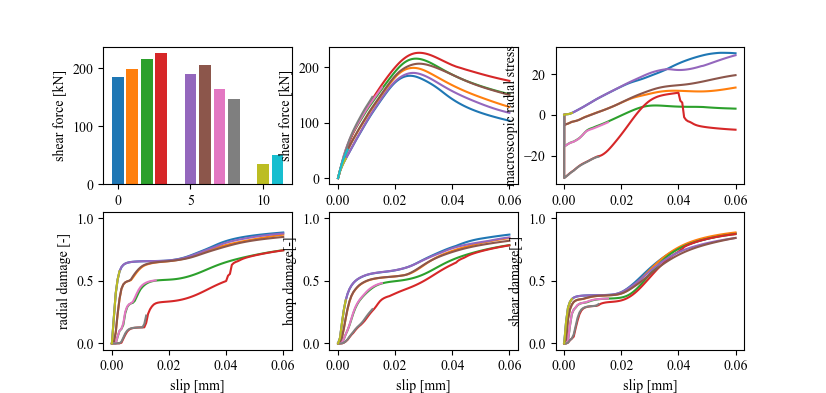

In [19]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"



fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2, 3,figsize=(21*cm, 10*cm))

for i in range(len(m_parameter_list)):
    m_T = m_parameter_list[i]
    print(m_T)
    

    for j in range(len(compression_level)):
        m = m_list_parameter_m[i*(len(m_parameter_list)-1) + j]
        U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
        U_dilatancy  =m.hist.U_t[:, confinement_upper_dofs[0]]
        F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
        radial_damage, hoop_damage, shear_damage = get_damage(m)

        F_confinement = np.sum(m.hist.F_t[:, confinement_upper_dofs], axis=-1)
        F_max = (max(abs(F_slide/1000)))

        ax1.bar((i*len(m_parameter_list)+j), F_max)
        ax1.set_ylabel('shear force [kN]', fontsize=10)
        ax1.set_xlabel('Simmulation Nr. [-]', fontsize=10)

        ax2.plot(U_slide, F_slide/1000, label=str(compression))
        ax2.set_ylabel('shear force [kN]', fontsize=10)
        ax2.set_xlabel('slip [mm]', fontsize=10)
        
        sigma_N_01, sigma_N_11, sigma_radial = get_sigma_N(m) 
        ax3.plot(U_slide, sigma_radial)
        ax3.set_ylabel('macroscopic radial stress', fontsize=10)
        ax3.set_xlabel('slip [mm]', fontsize=10)


        # ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
        ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
        ax4.set_ylabel('radial damage [-]', fontsize=10)
        ax4.set_xlabel('slip [mm]', fontsize=10)
        ax4.set_ylim(-0.05,1.05)

        ax5.plot(U_slide, hoop_damage, label='hoop damage'+str(compression))
        ax5.set_ylabel('hoop damage[-]', fontsize=10)
        ax5.set_xlabel('slip [mm]', fontsize=10)
        ax5.set_ylim(-0.05,1.05)

        # ax6.plot(F_slide/1000, shear_damage, label='shear damage'+str(compression))
        ax6.plot(U_slide, shear_damage, label='shear damage'+str(compression))
        ax6.set_ylabel('shear damage[-]', fontsize=10)
        ax6.set_xlabel('slip [mm]', fontsize=10)
        ax6.set_ylim(-0.05,1.05)
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

txt=str(CAxisymm)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)

# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\pdf\\study01_monotonic_' + str(simmulation_number) + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\png\\study01_monotonic_' + str(simmulation_number) + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

### p parameter

In [ ]:
CAxisymm = dict(
    E = 40e+3,
    nu = 0.2,
    Ad = 7000.0,
    eps_0 = 0.00001,
    K_N = 200.,
    sigma_N_0 = 40.,
    gamma_N = 5000.,
    sigma_T_0 = 2.0,
    K_T = 100.0,
    gamma_T = 20000,
    S_T = 0.005,
    c_T = 5.,
    r_T = 6.,
    m_T = 0.0,
    p_T = 6.
)

In [51]:
m_list_parameter_p = []
# compression_level = np.linspace(-20,10,3)
compression_level = np.array([0,-5,-15,-30])
p_parameter_list = np.array([2,4,6,8,10])
CAxisymm['m_T'] = 0.2
w_max = 0.03
for p_parameter in p_parameter_list:
    CAxisymm['p_T'] = p_parameter
    m_inelastic = MS13D(**CAxisymm)
    for compression in compression_level:
        
        m = TStepBC(
        domains=[(xmodel, m_inelastic),
                 ]
        )
        # Shear bc
        slide = 0.06
        compression_stress = compression

        inner_fixed_0 = slide_lower_slice
        inner_fixed_1 = confinement_lower_slice

        compression_force = compression_stress * 2 * np.pi * (R_in + dR) * len_notch  / (len(confinement_upper_dofs))
        upper_compression_force = [BCDof(var='f', dof=dof, value=compression_force, 
                                         time_function=tf_precrompression)
                                   for dof in confinement_upper_dofs]



        slide_upper = [BCDof(var='u', dof=dof, value=slide, time_function=tf_sliding)
                             for dof in slide_upper_dofs]


        bc1 = [inner_fixed_0, inner_fixed_1] + slide_upper + upper_compression_force

        m.bc=bc1
        m.hist.vis_record = {
        #    'strain': Vis3DTensorField(var='eps_ab'),
            'stress': Vis3DTensorField(var='sig_ab'),
            #        'kinematic hardening': Vis3DStateField(var='z_a')
        }

        s = m.sim
        s.tloop.verbose = False
        s.tloop.k_max = 1000
        s.tline.step = 0.01
        # Accessing the following property - ensures serialization
        s.tstep.fe_domain.serialized_subdomains
        s.reset()
        # s.run()
        try:
            s.run()
        except:
            pass
        m_list_parameter_p.append(m)

2
4
6
8
10


Text(0.5, 0.01, "{'E': 40000.0, 'nu': 0.2, 'Ad': 7000.0, 'eps_0': 1e-05, 'K_N': 200.0, 'sigma_N_0': 40.0, 'gamma_N': 5000.0, 'sigma_T_0': 2.0, 'K_T': 100.0, 'gamma_T': 20000, 'S_T': 0.005, 'c_T': 5.0, 'r_T': 6.0, 'm_T': 0.2, 'p_T': 10}")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
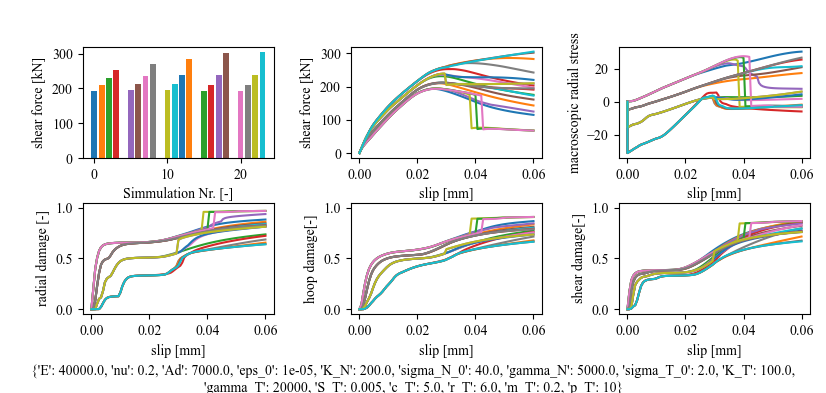

In [53]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"



fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2, 3,figsize=(21*cm, 10*cm))

for i in range(len(p_parameter_list)):
    p = p_parameter_list[i]
    print(p)
    

    for j in range(len(compression_level)):
        m = m_list_parameter_p[i*(len(m_parameter_list)-1) + j]
        U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
        U_dilatancy  =m.hist.U_t[:, confinement_upper_dofs[0]]
        F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
        radial_damage, hoop_damage, shear_damage = get_damage(m)

        F_confinement = np.sum(m.hist.F_t[:, confinement_upper_dofs], axis=-1)
        F_max = (max(abs(F_slide/1000)))

        ax1.bar((i*len(m_parameter_list)+j), F_max)
        ax1.set_ylabel('shear force [kN]', fontsize=10)
        ax1.set_xlabel('Simmulation Nr. [-]', fontsize=10)

        ax2.plot(U_slide, F_slide/1000, label=str(compression))
        ax2.set_ylabel('shear force [kN]', fontsize=10)
        ax2.set_xlabel('slip [mm]', fontsize=10)
        
        sigma_N_01, sigma_N_11, sigma_radial = get_sigma_N(m) 
        ax3.plot(U_slide, sigma_radial)
        ax3.set_ylabel('macroscopic radial stress', fontsize=10)
        ax3.set_xlabel('slip [mm]', fontsize=10)


        # ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
        ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
        ax4.set_ylabel('radial damage [-]', fontsize=10)
        ax4.set_xlabel('slip [mm]', fontsize=10)
        ax4.set_ylim(-0.05,1.05)

        ax5.plot(U_slide, hoop_damage, label='hoop damage'+str(compression))
        ax5.set_ylabel('hoop damage[-]', fontsize=10)
        ax5.set_xlabel('slip [mm]', fontsize=10)
        ax5.set_ylim(-0.05,1.05)

        # ax6.plot(F_slide/1000, shear_damage, label='shear damage'+str(compression))
        ax6.plot(U_slide, shear_damage, label='shear damage'+str(compression))
        ax6.set_ylabel('shear damage[-]', fontsize=10)
        ax6.set_xlabel('slip [mm]', fontsize=10)
        ax6.set_ylim(-0.05,1.05)
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

txt=str(CAxisymm)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)

# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\pdf\\study01_monotonic_' + str(simmulation_number) + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\png\\study01_monotonic_' + str(simmulation_number) + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

### $\sigma^{0}_{T}$ parameter

In [ ]:
m_list_parameter_sigma = []
# compression_level = np.linspace(-20,10,3)
compression_level = np.array([0,-5,-15,-30])
sigma_parameter_list = np.array([2,4,6,8,10])
CAxisymm['m_T'] = 0.2
w_max = 0.03
for sigma_parameter in sigma_parameter_list:
    CAxisymm['sigma_T_0'] = sigma_parameter
    m_inelastic = MS13D(**CAxisymm)
    for compression in compression_level:
        
        m = TStepBC(
        domains=[(xmodel, m_inelastic),
                 ]
        )
        # Shear bc
        slide = 0.06
        compression_stress = compression

        inner_fixed_0 = slide_lower_slice
        inner_fixed_1 = confinement_lower_slice

        compression_force = compression_stress * 2 * np.pi * (R_in + dR) * len_notch  / (len(confinement_upper_dofs))
        upper_compression_force = [BCDof(var='f', dof=dof, value=compression_force, 
                                         time_function=tf_precrompression)
                                   for dof in confinement_upper_dofs]



        slide_upper = [BCDof(var='u', dof=dof, value=slide, time_function=tf_sliding)
                             for dof in slide_upper_dofs]


        bc1 = [inner_fixed_0, inner_fixed_1] + slide_upper + upper_compression_force

        m.bc=bc1
        m.hist.vis_record = {
        #    'strain': Vis3DTensorField(var='eps_ab'),
            'stress': Vis3DTensorField(var='sig_ab'),
            #        'kinematic hardening': Vis3DStateField(var='z_a')
        }

        s = m.sim
        s.tloop.verbose = False
        s.tloop.k_max = 1000
        s.tline.step = 0.01
        # Accessing the following property - ensures serialization
        s.tstep.fe_domain.serialized_subdomains
        s.reset()
        # s.run()
        try:
            s.run()
        except:
            pass
        m_list_parameter_p.append(m)

In [ ]:
cm = 1/2.54  # centimeters in inches
# plt.style.use('grayscale')
plt.style.use('default')

plt.tight_layout()
max_F = []
plt.rcParams["font.family"] = "Times New Roman"



fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2, 3,figsize=(21*cm, 10*cm))

for i in range(len(p_parameter_list)):
    p = m_parameter_list[i]
    print(p)
    

    for j in range(len(compression_level)):
        m = m_list_parameter_p[i*(len(m_parameter_list)-1) + j]
        U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
        U_dilatancy  =m.hist.U_t[:, confinement_upper_dofs[0]]
        F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
        radial_damage, hoop_damage, shear_damage = get_damage(m)

        F_confinement = np.sum(m.hist.F_t[:, confinement_upper_dofs], axis=-1)
        F_max = (max(abs(F_slide/1000)))

        ax1.bar((i*len(m_parameter_list)+j), F_max)
        ax1.set_ylabel('shear force [kN]', fontsize=10)
        ax1.set_xlabel('Simmulation Nr. [-]', fontsize=10)

        ax2.plot(U_slide, F_slide/1000, label=str(compression))
        ax2.set_ylabel('shear force [kN]', fontsize=10)
        ax2.set_xlabel('slip [mm]', fontsize=10)
        
        sigma_N_01, sigma_N_11, sigma_radial = get_sigma_N(m) 
        ax3.plot(U_slide, sigma_radial)
        ax3.set_ylabel('macroscopic radial stress', fontsize=10)
        ax3.set_xlabel('slip [mm]', fontsize=10)


        # ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
        ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
        ax4.set_ylabel('radial damage [-]', fontsize=10)
        ax4.set_xlabel('slip [mm]', fontsize=10)
        ax4.set_ylim(-0.05,1.05)

        ax5.plot(U_slide, hoop_damage, label='hoop damage'+str(compression))
        ax5.set_ylabel('hoop damage[-]', fontsize=10)
        ax5.set_xlabel('slip [mm]', fontsize=10)
        ax5.set_ylim(-0.05,1.05)

        # ax6.plot(F_slide/1000, shear_damage, label='shear damage'+str(compression))
        ax6.plot(U_slide, shear_damage, label='shear damage'+str(compression))
        ax6.set_ylabel('shear damage[-]', fontsize=10)
        ax6.set_xlabel('slip [mm]', fontsize=10)
        ax6.set_ylim(-0.05,1.05)
left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

txt=str(CAxisymm)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)

# simmulation_number = np.load('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number.npy')
# simmulation_number += 1
# np.save('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\simmulation_number', simmulation_number)
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\pdf\\study01_monotonic_' + str(simmulation_number) + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study01_elementary_studies\\png\\study01_monotonic_' + str(simmulation_number) + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

In [70]:
i*len(m_parameter_list) + j

20

In [75]:
CAxisymm['m_T']

0.2

In [72]:
j

0

In [12]:
max_F

[149353.5161902968, 201261.46404574075, 217753.04869582749, 228308.42426441208]

In [30]:
m = m_list_monotnonic[0]
idx = 30

In [31]:
U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
F_slide[idx]

91653.68222382391

In [34]:
eps_Emab = xmodel.map_U_to_field(m.hist.U_t[idx])
# print(eps_Emab)
# vol = (eps_Emab[...,0,0] + eps_Emab[...,1,1] + eps_Emab[...,2,2])/3
# print(vol)
# eps_Emab=np.zeros_like(eps_Emab)
# eps_Emab[...,0,0] = eps_Emab[...,1,1] = eps_Emab[...,2,2] = vol
# eps_Emab[...,0,0] = eps_Emab[...,1,1] = 0.0
eps_N_Emn = m_inelastic._get_e_N_Emn_2(eps_Emab)
print(np.array([ eps_N_Emn[0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]]))
# E_N = m_inelastic.E / (1.0 - 2.0 * m_inelastic.nu)
omega_N_Emn = m.hist.state_vars[idx][0]['omega_N_Emn']
eps_N_p_Emn = m.hist.state_vars[idx][0]['eps_N_p_Emn']
# sigma_N_Emn = (1.0 - omega_N_Emn ) * E_N * (eps_N_Emn - eps_N_p_Emn)
# # sigma_N_Emn = 2/(2-sigma_N_Emn)
# sigma_T_Emn = np.sqrt(
#     np.einsum(
#         '...na,...na->...n',
#         (sigma_T_Emna), (sigma_T_Emna))
# )
# print(eps_N_Emn* E_N * np.einsum('...ik,...i->...ik', sigma_T_Emn , 1/np.max(sigma_T_Emn[0],axis=1)))
# # sigma_N_Emn - sigma_N_Emn0



[0.00148755 0.00148755 0.00046113 0.00046113 0.00083739 0.00083739
 0.00027082 0.00027082]


In [16]:
E_T = m_inelastic.E * (1.0 - 4 * m_inelastic.nu) / \
            ((1.0 + m_inelastic.nu) * (1.0 - 2 * m_inelastic.nu))
omega_T_Emn = m.hist.state_vars[idx][0]['omega_T_Emn']
eps_T_pi_Emna = m.hist.state_vars[idx][0]['eps_T_pi_Emna']
eps_T_Emna = m_inelastic._get_e_T_Emnar_2(eps_Emab)
sigma_T_Emna = np.einsum(
            '...n,...na->...na', (1 - omega_T_Emn), E_T * (eps_T_Emna - eps_T_pi_Emna))

sigma_T_Emn = np.sqrt(
    np.einsum(
        '...na,...na->...n',
        (sigma_T_Emna), (sigma_T_Emna))
)
print(omega_N_Emn) 
# print(eps_N_Emn) 
print(sigma_T_Emn) 

[[[0.84707399 0.84707399 0.84707399 0.84707399 0.14820266 0.14820266
   0.14820266 0.14820266 0.97300111 0.97300111 0.97300111 0.97300111
   0.26935309 0.26935309 0.26935309 0.26935309 0.9208846  0.9208846
   0.9208846  0.9208846  0.08767241 0.08767241 0.08767241 0.08767241
   0.91641685 0.91641685 0.91641685 0.91641685]
  [0.84707399 0.84707399 0.84707399 0.84707399 0.14820266 0.14820266
   0.14820266 0.14820266 0.97300111 0.97300111 0.97300111 0.97300111
   0.26935309 0.26935309 0.26935309 0.26935309 0.9208846  0.9208846
   0.9208846  0.9208846  0.08767241 0.08767241 0.08767241 0.08767241
   0.91641685 0.91641685 0.91641685 0.91641685]
  [0.86535011 0.86535011 0.86535011 0.86535011 0.17045032 0.17045032
   0.17045032 0.17045032 0.97329746 0.97329746 0.97329746 0.97329746
   0.54334255 0.54334255 0.54334255 0.54334255 0.93103809 0.93103809
   0.93103809 0.93103809 0.25722132 0.25722132 0.25722132 0.25722132
   0.91728275 0.91728275 0.91728275 0.91728275]
  [0.86535011 0.86535011 0.865

In [31]:
beta_N = 1. - omega_N_Emn
beta_T = 1. - omega_T_Emn
delta = m_inelastic.DELTA

beta_Emabcd = np.einsum('n, ...n,ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_N, m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN,
                      m_inelastic._MPN) + \
            0.25 * (np.einsum('n, ...n,ni, nk, jl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                    np.einsum('n, ...n,ni, nl, jk -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                    np.einsum('n, ...n,nj, nk, il -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                    np.einsum('n, ...n,nj, nl, ik -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) -
                    4.0 * np.einsum('n, ...n, ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN,
                                    m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN))

D_Emabcd = np.einsum(
             '...ijab, abef, ...cdef->...ijcd',
             beta_Emabcd, m_inelastic.D_abef, beta_Emabcd
        )


eps_p_Emab = (
np.einsum('n,...n,na,nb->...ab',
          m_inelastic._MPW, eps_N_p_Emn, m_inelastic._MPN, m_inelastic._MPN) +
0.5 * (
        np.einsum('n,...nf,na,fb->...ab',
                  m_inelastic._MPW, eps_T_pi_Emna, m_inelastic._MPN, m_inelastic.DELTA) +
        np.einsum('n,...nf,nb,fa->...ab',
                  m_inelastic._MPW, eps_T_pi_Emna, m_inelastic._MPN, m_inelastic.DELTA)
)
)
# elastic strain tensor
eps_e_Emab = eps_Emab - eps_p_Emab

# calculation of the stress tensor
# sig_Emab = np.einsum(
#     '...abcd,...cd,...ab->...ab',
#     D_Emabcd, eps_e_Emab, m_inelastic.DELTA
#         )
sig_Emab = np.einsum(
    '...abcd,...cd->...ab',
    D_Emabcd, eps_e_Emab
        )
print(sig_Emab)
# sigma_Emab = np.einsum('n, nij, ...n -> ...ij', m_inelastic._MPW, m_inelastic._MPNN, sigma_N_Emn) + np.einsum('n, nkij, ...nk -> ...ij', m_inelastic._MPW, m_inelastic._MPTT, sigma_T_Emna)
    
sigma_N_Emn_projected = m_inelastic._get_e_N_Emn_2(sig_Emab)
sigma_N_Emn_projected * (1 + 1.2**sigma_N_Emn_projected)

[[[[-13.26292324  16.672797     0.        ]
   [ 16.672797     2.43722005   0.        ]
   [  0.           0.          -7.10484166]]

  [[-12.98742912  19.7307896    0.        ]
   [ 19.7307896   -6.08711756   0.        ]
   [  0.           0.          -7.24135555]]

  [[-12.60306317  18.97308969   0.        ]
   [ 18.97308969  -5.70900199   0.        ]
   [  0.           0.          -6.32208494]]

  [[-12.89170476  15.84491933   0.        ]
   [ 15.84491933   2.48533342   0.        ]
   [  0.           0.          -5.68196638]]]]


array([[[ 18.25082118,  18.25082118, -17.84961883, -17.84961883,
          -6.01641177,  -6.01641177, -20.24613503, -20.24613503,
          50.73216802,  50.73216802,  -8.91713718,  -8.91713718,
          -6.79948925,  -6.79948925, -10.73189545, -10.73189545,
           3.74220469,   3.74220469,  -8.97681333,  -8.97681333,
          -7.45152607,  -7.45152607, -15.14242432, -15.14242432,
          84.32103042,  84.32103042, -21.98928256, -21.98928256],
        [ 14.12338169,  14.12338169, -22.32839666, -22.32839666,
          -4.66955793,  -4.66955793, -21.86963377, -21.86963377,
           6.95712395,   6.95712395, -16.72106028, -16.72106028,
          -7.06330666,  -7.06330666, -11.62121537, -11.62121537,
          -3.06629491,  -3.06629491, -13.33461032, -13.33461032,
          -6.87533591,  -6.87533591, -16.0432391 , -16.0432391 ,
          64.68055516,  64.68055516, -28.66245954, -28.66245954],
        [ 14.40234372,  14.40234372, -21.32525279, -21.32525279,
          -4.58987004, 

In [ ]:
E_T = m_inelastic.E * (1.0 - 4 * m_inelastic.nu) / \
            ((1.0 + m_inelastic.nu) * (1.0 - 2 * m_inelastic.nu))
omega_T_Emn = m.hist.state_vars[60][0]['omega_T_Emn']
eps_T_pi_Emna = m.hist.state_vars[-1][0]['eps_T_pi_Emna']
eps_T_Emna = m_inelastic._get_e_T_Emnar_2(eps_Emab)
sigma_T_Emna = np.einsum(
            '...n,...na->...na', (1 - omega_T_Emn), E_T * (eps_T_Emna - eps_T_pi_Emna))
sigma_T_Emna = np.sqrt(
    np.einsum(
        '...na,...na->...n',
        (sigma_T_Emna), (sigma_T_Emna))
)

omega_T_Emn 

In [ ]:
sigma_N_Emn

In [ ]:
(m_inelastic.sigma_T_0 / (m_inelastic.sigma_T_0 - 0.2 * sigma_N_Emn)) 

In [ ]:
max_F = [172794.69026158043, 193590.32518623563, 211936.75288141266]

In [61]:
if True:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

## Monotonic - fc - obtaining peak load for fc

In [19]:
m_list_monotnonic = []
# compression_level = np.array([-5])

w_max = 0.03

for compression, slide in zip(compression_level, max_F):
# for compression in compression_level:

    m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
    )
    # Shear bc
        
    compression_stress = compression

    inner_fixed_0 = slide_lower_slice
    inner_fixed_1 = confinement_lower_slice

    compression_force = compression_stress * 2 * np.pi * (R_in + dR) * len_notch / (len(confinement_upper_dofs))
    upper_compression_force = [BCDof(var='f', dof=dof, value=compression_force, 
                                     time_function=tf_precrompression)
                               for dof in confinement_upper_dofs]   
    # upper_compression_force[0].value *= 0.5
    # upper_compression_force[-1].value *= 0.5
    slide_force = slide/ (len(slide_upper_dofs))
    # slide_force = 210000/ (len(slide_upper_dofs))

    slide_upper = [BCDof(var='f', dof=dof, value=slide_force, time_function=tf_sliding)
                         for dof in slide_upper_dofs]
    # slide_upper[0].value *= 0.5
    # slide_upper[-1].value *= 0.5
    bc1 = [inner_fixed_0, inner_fixed_1] + slide_upper + upper_compression_force

    m.bc=bc1
    m.hist.vis_record = {
    #    'strain': Vis3DTensorField(var='eps_ab'),
        'stress': Vis3DTensorField(var='sig_ab'),
        #        'kinematic hardening': Vis3DStateField(var='z_a')
    }

    s = m.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tloop.acc = 1e-4
    s.tline.step = 0.018/1
    # Accessing the following property - ensures serialization
    s.tstep.fe_domain.serialized_subdomains
    s.reset()
    try:
        s.run()
    except:
        pass
    m_list_monotnonic.append(m)

c:\users\marag\pycharmprojects\bmcs_matmod\bmcs_matmod\ms1\ms1.py:380: RuntimeWarning: overflow encountered in multiply
  (delta_lamda * (Y / self.S_T) ** self.r_T) * \
c:\users\marag\pycharmprojects\bmcs_matmod\bmcs_matmod\ms1\ms1.py:380: RuntimeWarning: overflow encountered in power
  (delta_lamda * (Y / self.S_T) ** self.r_T) * \


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
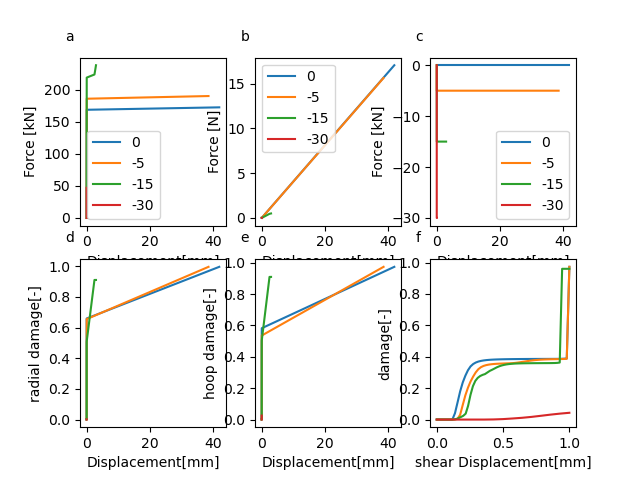

In [20]:
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2, 3)
max_F = []
for m,compression in zip(m_list_monotnonic,compression_level):
    U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
    U_dilatancy = np.average(m.hist.U_t[:, confinement_upper_dofs], axis=-1)
    F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
    F_confinement = np.sum(m.hist.F_t[:, confinement_upper_dofs], axis=-1)
    
    # print(max(abs(F_slide)))
    # print(F_slide)
    max_F.append(max(abs(F_slide)))
    radial_damage, hoop_damage, shear_damage = get_damage(m)
    ax1.plot(U_slide, F_slide/1000, label=str(compression))
    ax1.set_ylabel('Force [kN]')
    ax1.set_xlabel('Displacement[mm]')
    ax2.plot(U_slide, U_dilatancy, label=str(compression))
    ax2.set_ylabel('Force [N]')
    ax2.set_xlabel('Displacement[mm]')
    ax3.plot(U_slide, F_confinement/(2 *  np.pi * (R_in + dR) * len_notch ), label=str(compression))
    ax3.set_ylabel('Force [kN]')
    ax3.set_xlabel('Displacement[mm]')
    ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
    ax4.set_ylabel('radial damage[-]')
    ax4.set_xlabel('Displacement[mm]')
    ax5.plot(U_slide, hoop_damage, label='hoop damage'+str(compression))
    ax5.set_ylabel('hoop damage[-]')
    ax5.set_xlabel('Displacement[mm]')
    ax6.plot(np.linspace(0,1,len(shear_damage)), shear_damage, label='shear damage'+str(compression))
    ax6.set_ylabel('damage[-]')
    ax6.set_xlabel('shear Displacement[mm]')
import string

for n, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):     
    ax.text(-0.1, 1.1, string.ascii_lowercase[n], transform=ax.transAxes, 
            size=10)    
ax1.legend()
ax2.legend()
ax3.legend()

In [21]:
max_F

[172312.3404913105, 189915.12814466667, 237900.0046241101, 46886.16043721179]

In [22]:
if False:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

## Cyclic

In [23]:
number_of_cycles = 5
shift_cycles = 1
steps_branch = 50
tf_cyclic = TFCyclicNonsymmetricConstant(number_of_cycles=number_of_cycles, unloading_ratio=0.05, shift_cycles=shift_cycles)
tf_confinement = TFBilinear(loading_ratio=1, time_ratio=1/(number_of_cycles+shift_cycles))

In [25]:
m_list = []
# compression_level = np.linspace(0,-30,3)
compression_level = np.array([0,-5,-15,-30])

S_max = 0.85
w_max = 0.2

# for compression, slide in zip([compression_level[1]], [max_F[1]]):
for compression, slide in zip(compression_level, max_F):
# compression = compression_level[3]
# slide = max_F[3]    
    m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
    )
    # Shear bc
    compression_stress = compression

    inner_fixed_0 = slide_lower_slice
    inner_fixed_1 = confinement_lower_slice

    compression_force = compression_stress * 2 * np.pi * (R_in + dR) * len_notch / (len(confinement_upper_dofs))
    upper_compression_force = [BCDof(var='f', dof=dof, value=compression_force, 
                                     time_function=tf_confinement)
                               for dof in confinement_upper_dofs]
    # upper_compression_force[0].value *= 0.5
    # upper_compression_force[-1].value *= 0.5
    slide_force = S_max * slide / (len(slide_upper_dofs))
    slide_upper = [BCDof(var='f', dof=dof, value=slide_force, time_function=tf_cyclic)
                         for dof in slide_upper_dofs]
    # slide_upper[0].value *= 0.5
    # slide_upper[-1].value *= 0.5
    bc1 = [inner_fixed_0, inner_fixed_1] + slide_upper + upper_compression_force

    m.bc=bc1
    m.hist.vis_record = {
    #    'strain': Vis3DTensorField(var='eps_ab'),
        'stress': Vis3DTensorField(var='sig_ab'),
        #        'kinematic hardening': Vis3DStateField(var='z_a')
    }

    s = m.sim
    s.tloop.verbose = False
    s.tloop.k_max = 1000
    s.tloop.acc = 1e-2
    s.tline.step = 1/(steps_branch*2*(number_of_cycles+1))
    # Accessing the following property - ensures serialization
    s.tstep.fe_domain.serialized_subdomains
    s.reset()
    # s.run()
    try:
        s.run()
    except:
        pass
    m_list.append(m)

[0.   1.25 2.5  3.75 5.  ]
[0.   1.25 2.5  3.75 5.  ]
[0.   1.25 2.5  3.75 5.  ]
[]


IndexError: index -1 is out of bounds for axis 0 with size 0

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
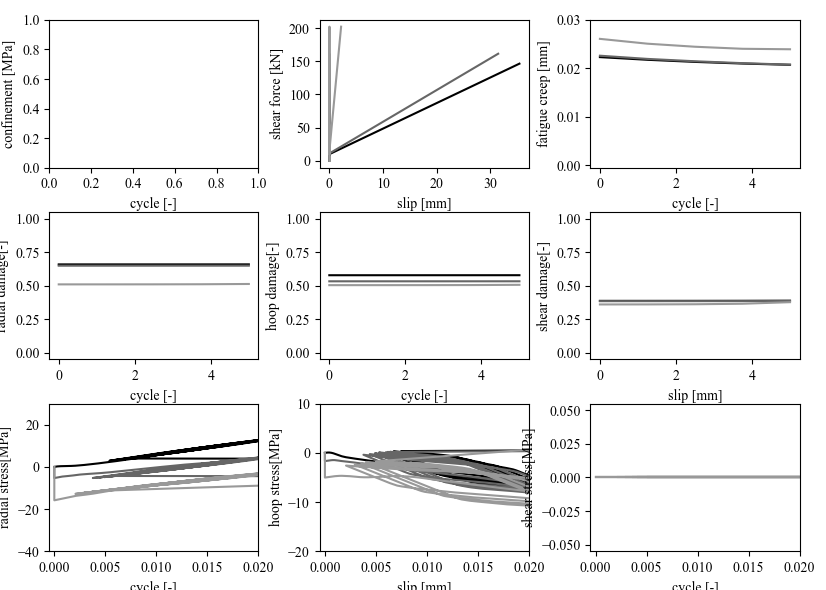

In [26]:
cm = 1/2.54  # centimeters in inches
plt.style.use('grayscale')
N=[]
plt.tight_layout()
plt.rcParams["font.family"] = "Times New Roman"

fig, ((ax1,ax2,ax3), (ax4,ax5,ax6), (ax7,ax8,ax9)) = plt.subplots(3, 3,figsize=(21*cm, 15*cm))

start = int((shift_cycles+2)*steps_branch)
end = int(steps_branch)
plt.tight_layout()

for m,compression in zip(m_list,compression_level):
    # m = m_list[0]
    # compression = compression_level[3]
    U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
    cycles = np.linspace(0, len(U_slide[start::steps_branch*2]),len(U_slide[start:-steps_branch:steps_branch*2]))

    # print(U_slide[start::steps_branch].shape)
    radial_damage, hoop_damage, shear_damage = get_damage(m)
    U_dilatancy = np.average(m.hist.U_t[:, confinement_upper_dofs], axis=-1)
    F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
    print(cycles)
    # print(F_slide[start::steps_branch*2].shape)
    F_confinement = np.sum(m.hist.F_t[:, confinement_upper_dofs], axis=-1)

    N.append(cycles[-1])
    # ax1.plot(cycles, F_confinement[start:-steps_branch:steps_branch*2]/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)), label=str(compression))
    # ax1.plot(U_slide, F_confinement/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)), label=str(compression))
    ax1.set_ylabel('confinement [MPa]')
    ax1.set_xlabel('cycle [-]')
    # ax1.set_xlim(-5,55)

    ax2.plot(U_slide, F_slide/1000, label=str(compression))
    ax2.set_ylabel('shear force [kN]')
    ax2.set_xlabel('slip [mm]')
    # ax2.set_ylim(-1,130)
    # ax2.set_xlim(-0.0005,0.02)

    ax3.plot(cycles, U_slide[start:-end:steps_branch*2], label=str(compression))
    # ax3.plot(cycles[1:], U_slide[start+steps_branch:-end:steps_branch*2], label=str(compression))
    ax3.set_ylabel('fatigue creep [mm]')
    ax3.set_xlabel('cycle [-]')
    ax3.set_ylim(-0.0005,0.03)


    ax4.plot(cycles, radial_damage[start:-end:steps_branch*2], label='radial damage'+str(compression))
    ax4.set_ylabel('radial damage[-]')
    ax4.set_xlabel('cycle [-]')
    ax4.set_ylim(-0.05,1.05)

    ax5.plot(cycles, hoop_damage[start:-end:steps_branch*2], label='hoop damage'+str(compression))
    ax5.set_ylabel('hoop damage[-]')
    ax5.set_xlabel('cycle [-]')
    ax5.set_ylim(-0.05,1.05)

    ax6.plot(cycles, shear_damage[start:-end:steps_branch*2], label='shear damage'+str(compression))
    ax6.set_ylabel('shear damage[-]')
    ax6.set_xlabel('slip [mm]')
    ax6.set_ylim(-0.05,1.05)

    sigma_radial, sigma_hoop, sigma_shear = get_sigma(m,3)  

    ax7.plot(U_slide, sigma_radial)
    # ax7.plot(cycles, sigma_radial[start:-end:steps_branch*2])
    ax7.set_ylabel('radial stress[MPa]')
    ax7.set_xlabel('cycle [-]')
    ax7.set_xlim(-0.0005,0.02)
    ax7.set_ylim(-40,30)

    ax8.plot(U_slide, sigma_hoop)
    # ax8.plot(cycles, sigma_hoop[start:-end:steps_branch*2])
    ax8.set_ylabel('hoop stress[MPa]')
    ax8.set_xlabel('slip [mm]')
    ax8.set_xlim(-0.0005,0.02)
    ax8.set_ylim(-20,10)

    ax9.plot(U_slide, sigma_shear)
    # ax9.plot(cycles, sigma_shear[start:-end:steps_branch*2])
    ax9.set_ylabel('shear stress[MPa]')
    ax9.set_xlabel('cycle [-]')
    ax9.set_xlim(-0.0005,0.02)

ax1.plot(N, compression_level,  '--ks', markersize=4)  

left  = 0.1  # the left side of the subplots of the figure
right = 0.98  # the right side of the subplots of the figure
bottom = 0.2   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.4   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["k", "r", "b"]) 
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=None, wspace=wspace, hspace=hspace)

txt=str(CAxisymm)
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=10)
# ax1.set_xlim(-1,21)
ax1.set_ylim(-32,2)

# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\pdf\\study03_cyclic_'  + '.pdf')
# fig.savefig('C:\\Users\\marag\\OneDrive - rwth-aachen.de\\EURO-C\\Figures\\study03_calibration\\png\\study03_cyclic_'  + '.png')
# ax1.legend()
# ax2.legend() 
# ax3.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
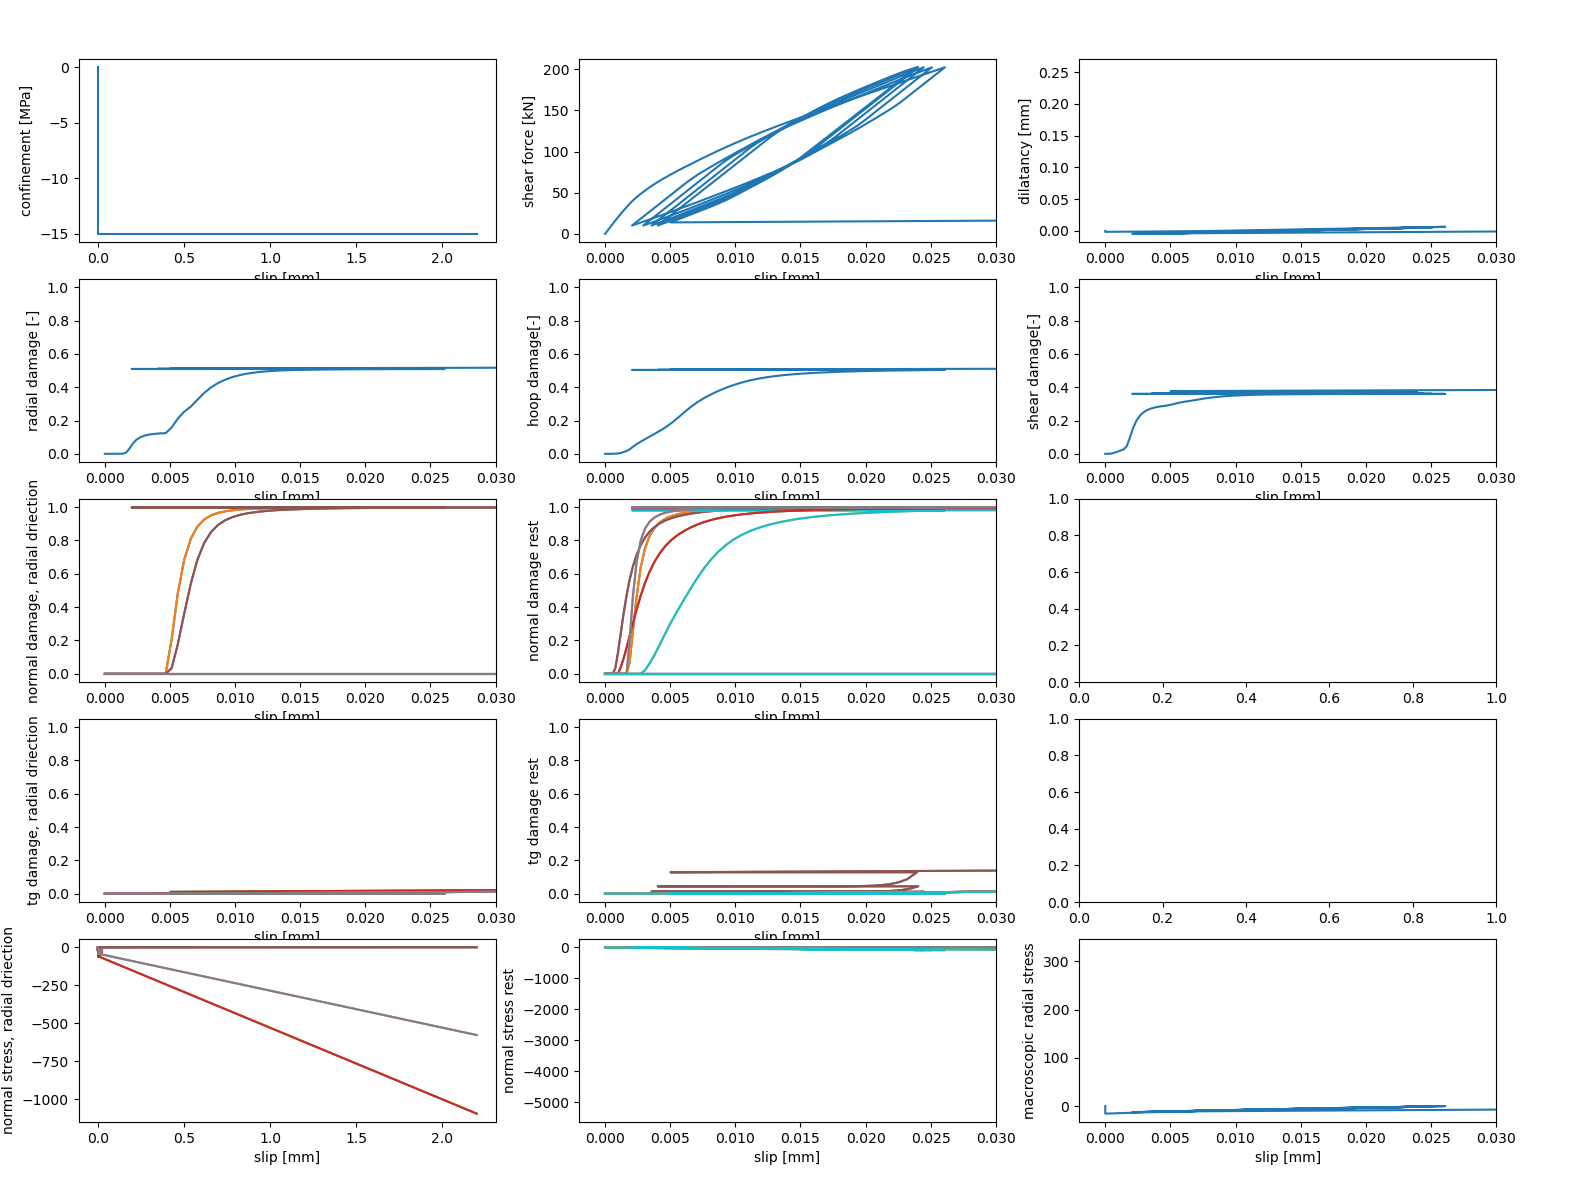

In [27]:
plt.style.use('default')

# plt.tight_layout()

cm = 1/2.54  # centimeters in inches
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6), (ax7,ax8,ax9), (ax10,ax11,ax12), (ax13,ax14,ax15)) = plt.subplots(5, 3,figsize=(40*cm, 30*cm))

# txt=str(CAxisymm)


idx = 2
m = m_list[idx]
# compression = compression_level[idx]
# plt.rcParams["font.family"] = "Times New Roman"
 
    
U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
U_dilatancy  =m.hist.U_t[:, confinement_upper_dofs[0]]
F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
radial_damage, hoop_damage, shear_damage = get_damage(m)

F_confinement = np.sum(m.hist.F_t[:, confinement_upper_dofs], axis=-1)


ax1.plot(U_slide, F_confinement/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)), label=str(compression))
ax1.set_ylabel('confinement [MPa]', fontsize=10)
ax1.set_xlabel('slip [mm]', fontsize=10)

ax2.plot(U_slide, F_slide/1000, label=str(compression))
ax2.set_ylabel('shear force [kN]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)
ax2.set_xlim(-0.002,0.03)

ax3.plot(U_slide, U_dilatancy, label=str(compression))
ax3.set_ylabel('dilatancy [mm]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)
ax3.set_xlim(-0.002,0.03)


# ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
ax4.set_ylabel('radial damage [-]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
ax4.set_ylim(-0.05,1.05)
ax4.set_xlim(-0.002,0.03)


ax5.plot(U_slide, hoop_damage, label='hoop damage'+str(compression))
ax5.set_ylabel('hoop damage[-]', fontsize=10)
ax5.set_xlabel('slip [mm]', fontsize=10)
ax5.set_ylim(-0.05,1.05)
ax5.set_xlim(-0.002,0.03)

# ax6.plot(F_slide/1000, shear_damage, label='shear damage'+str(compression))
ax6.plot(U_slide, shear_damage, label='shear damage'+str(compression))
ax6.set_ylabel('shear damage[-]', fontsize=10)
ax6.set_xlabel('slip [mm]', fontsize=10)
ax6.set_ylim(-0.05,1.05)
ax6.set_xlim(-0.002,0.03)

omega_N_01, omega_N_11 = get_omega_N(m) 
ax7.plot(U_slide, omega_N_11)
ax7.set_ylabel('normal damage, radial driection', fontsize=10)
ax7.set_xlabel('slip [mm]', fontsize=10)
ax7.set_ylim(-0.05,1.05)
ax7.set_xlim(-0.002,0.03)


ax8.plot(U_slide, omega_N_01, label='shear damage'+str(compression))
ax8.set_ylabel('normal damage rest', fontsize=10)
ax8.set_xlabel('slip [mm]', fontsize=10)
ax8.set_ylim(-0.05,1.05)
ax8.set_xlim(-0.002,0.03)

omega_T_01, omega_T_11 = get_omega_T(m) 
ax10.plot(U_slide, omega_T_11)
ax10.set_ylabel('tg damage, radial driection', fontsize=10)
ax10.set_xlabel('slip [mm]', fontsize=10)
ax10.set_ylim(-0.05,1.05)
ax10.set_xlim(-0.002,0.03)


ax11.plot(U_slide, omega_T_01, label='shear damage'+str(compression))
ax11.set_ylabel('tg damage rest', fontsize=10)
ax11.set_xlabel('slip [mm]', fontsize=10)
ax11.set_ylim(-0.05,1.05)
ax11.set_xlim(-0.002,0.03)
    
sigma_N_01, sigma_N_11, sigma_radial = get_sigma_N(m) 
ax13.plot(U_slide, sigma_N_11)
ax13.set_ylabel('normal stress, radial driection', fontsize=10)
ax13.set_xlabel('slip [mm]', fontsize=10)
# ax13.set_ylim(-0.05,1.05)
ax11.set_xlim(-0.002,0.03)


ax14.plot(U_slide, sigma_N_01, label='shear damage'+str(compression))
ax14.set_ylabel('normal stress rest', fontsize=10)
ax14.set_xlabel('slip [mm]', fontsize=10)
# ax14.set_ylim(-0.05,1.05)
ax14.set_xlim(-0.002,0.03)

ax15.plot(U_slide, sigma_radial)
ax15.set_ylabel('macroscopic radial stress', fontsize=10)
ax15.set_xlabel('slip [mm]', fontsize=10)
ax15.set_xlim(-0.002,0.03)

left  = 0.05  # the left side of the subplots of the figure
right = 0.95  # the right side of the subplots of the figure
bottom = 0.05   # the bottom of the subplots of the figure
top = 0.95      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)